In [15]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

titanic = pd.read_csv ('train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


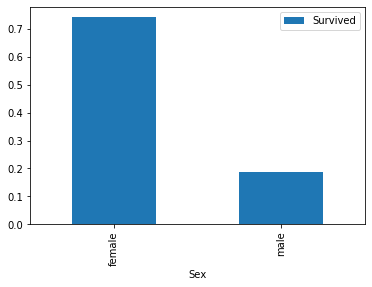

In [2]:
# prove what the movie showed

mf_pivot = titanic.pivot_table(index='Sex', values='Survived')
mf_pivot.plot.bar()
plt.show()

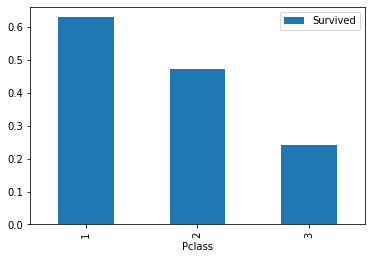

In [3]:
mf_pivot = titanic.pivot_table(index='Pclass', values='Survived')
mf_pivot.plot.bar()
plt.show()

In [4]:
titanic['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

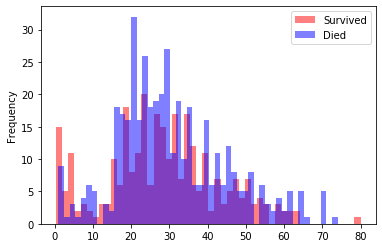

In [5]:
survived = titanic[titanic['Survived'] == 1]
died = titanic[titanic['Survived'] == 0]
survived['Age'].plot.hist(alpha=0.5, color='red', bins=50)
died['Age'].plot.hist(alpha=0.5, color='blue', bins=50)
plt.legend (['Survived', 'Died'])
plt.show()

In [6]:
# Let's group the ages

def group_ages(df, cut_points, label_names):
    df['Age'] = df['Age'].fillna(-0.5)
    df['Age_cat'] = pd.cut (df['Age'], cut_points, labels=label_names)
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
titanic = group_ages (titanic, cut_points, label_names)

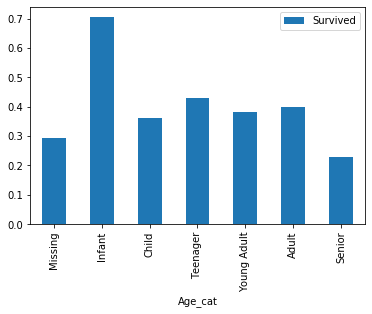

In [7]:
pt = titanic.pivot_table (index='Age_cat', values='Survived')
pt.plot.bar()
plt.show()

In [16]:
#####################################################
# Now let's prepare the data
#
# Columns are Age, Sex, Pclass

# First read in both train and test. Split train into my_train and my_test

def group_ages(df, cut_points, label_names):
    df['Age'] = df['Age'].fillna(-0.5)
    df['Age_cat'] = pd.cut (df['Age'], cut_points, labels=label_names)
    return df

def create_dummies (df, column_name):
    dummies = pd.get_dummies (df[column_name], prefix=column_name)
    df = pd.concat ([df, dummies], axis=1)
    return df

train = pd.read_csv ('train.csv')
test = pd.read_csv ('test.csv')

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
age_group_labels = ['Missing', 'Infant', 'Child', 'Teenager', 
    'Young Adult', 'Adult', 'Senior']
train = group_ages (train, cut_points, age_group_labels)
test = group_ages (test, cut_points, age_group_labels)

predictive_labels = ['Pclass', 'Sex', 'Age_cat']
for label in predictive_labels:
    train = create_dummies (train, label)
    test = create_dummies (test, label)

# Done with massaging data. Now split train into train & test
np.random.seed(1)
train = train.reindex(np.random.permutation(train.index))
train_max_row = math.floor (train.shape[0] * .8)
train_train = train.iloc[:train_max_row]
train_test = train.iloc[train_max_row:]

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age_cat_Missing', 'Age_cat_Infant', 'Age_cat_Child', 'Age_cat_Teenager', 'Age_cat_Young Adult', 'Age_cat_Adult', 'Age_cat_Senior']

target = ['Survived']

rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=1)
rf_model.fit (train_train[columns], train_train[target])
predictions = rf_model.predict (train_test[columns])
error = roc_auc_score (train_test[target], predictions)
error

0.8016115587663241

In [27]:
# Not bad. Now train on the whole training set and predict the test results
rf_model.fit (train[columns], train[target])
predictions = rf_model.predict (test[columns])

In [31]:
# Create the Kaggle submission file
kg_df = pd.DataFrame()
kg_df['PassengerId'] = test['PassengerId']
kg_df['Survived'] = predictions
kg_df.to_csv ('submission.csv', index=False)

In [35]:
kg_df['Survived'].value_counts()

0    302
1    116
Name: Survived, dtype: int64